In [19]:
%load_ext autoreload
%autoreload 2

import os

img_dir = "img/gaussfilter/"
if not os.path.isdir(img_dir):
    os.makedirs(img_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


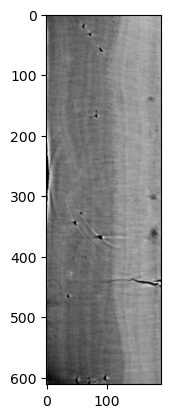

In [20]:
"""
Read in a straightened image

"""
import numpy as np
import matplotlib.pyplot as plt

image = np.load("cropped_image.npy")
plt.imshow(image, cmap="grey")

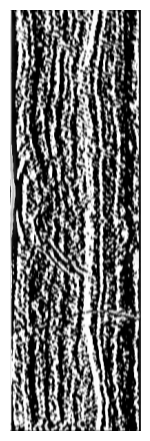

In [24]:
"""
Apply a steerable Gaussian filter to it

"""
from cementum import filter

sigma = 1.5

filtered = filter.steerable_filter(image, theta=0, sigma=sigma)

fig, axis = plt.subplots()
axis.imshow(filtered, cmap="grey")

fig.tight_layout()
axis.set_axis_off()

fig.savefig(f"{img_dir}/single_filter.png", bbox_inches="tight")

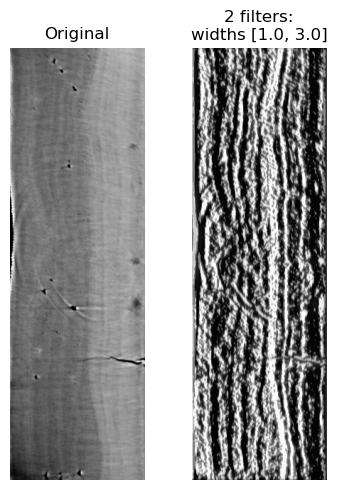

In [9]:
"""
Apply the average of multiple filters to it

"""
import os

filters = [1.0, 3.0]
multi_filtered = filter.apply_weighted_filters(image, widths=filters)

fig, axes = plt.subplots(1, 2, figsize=(4, 5))

axes[0].imshow(image, cmap="grey")
axes[1].imshow(multi_filtered, cmap="grey")

axes[0].set_title("Original")
axes[1].set_title(f"{len(filters)} filters:\nwidths {filters}")

for axis in axes:
    axis.axis("off")

fig.tight_layout()

img_dir = "img/gaussfilter"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

fig.savefig(f"{img_dir}/multi_filter.png", bbox_inches="tight")

What do we want this filter to do?
- Improve contrast between layers

What do we want it to avoid?
- 

Text(0.5, 0.98, 'Value greater than 0.56 indicates bimodality')

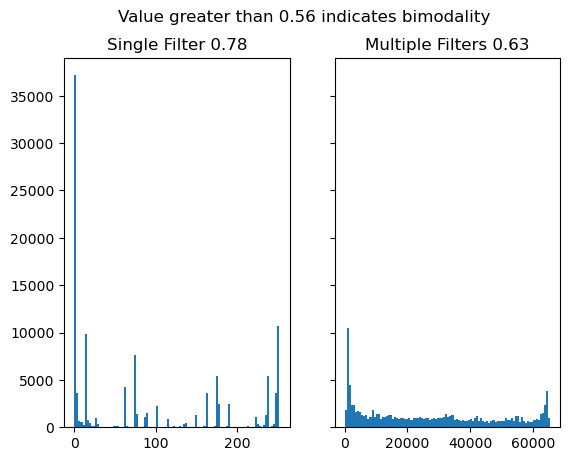

In [10]:
"""
Plot histograms and indicate the interquartile range

"""
from scipy import stats


def bimodality_coefficient(x):
    g1 = stats.skew(x)
    g2 = stats.kurtosis(x)

    n = len(x)
    return (g1**2 + 1) / (g2 + 3 * (n - 1) ** 2 / ((n - 2) * (n - 3)))


fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].hist(filtered.flat, bins=100)
axes[0].set_title(f"Single Filter {bimodality_coefficient(filtered.flat):.2f}")

axes[1].hist(multi_filtered.flat, bins=100)
axes[1].set_title(f"Multiple Filters {bimodality_coefficient(multi_filtered.flat):.2f}")

fig.suptitle(f"Value greater than {5/9:.2f} indicates bimodality")

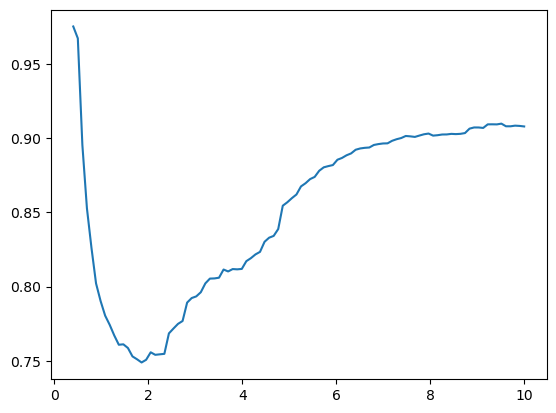

In [13]:
"""
Run many single filters, record the bimodality coefficient for each

"""
n = 100
widths = np.linspace(0.4, 10, n)
coeffs = np.full(n, np.nan)

for i, width in enumerate(widths):
    filtered = filter.apply_weighted_filters(image, widths=[width])
    coeffs[i] = bimodality_coefficient(filtered.flat)

plt.plot(widths, coeffs)